In [368]:
import glob
from PIL import Image
import numpy as np
import random
import json
import data_utils as utils
import matplotlib.pyplot as plt
from skimage import filters
from skimage import color, io
import cv2 as cv

In [2]:
def load_color_model(path):
    with open(path) as json_file:
        data = json.load(json_file)
        color_dict = {}
        color_terms = {}
        count_table = {}
        
        colors = data['color']
        terms = data['terms']
        T = data['T']
        print(len(colors))
        for i in range(int(len(colors)/3)):
            color_str = str(colors[i*3])+','+str(colors[i*3+1])+','+str(colors[i*3+2])
            if color_dict.get(color_str) is None:
                color_dict[color_str] = i
        for i in range(len(terms)):
            color_terms[terms[i]] = i
        for i in range(int(len(T)/2)):
            count_table[T[i*2]] = T[i*2+1]
            
    return color_dict, color_terms, count_table

def lookup(color, color_model):
    color_str = str(int(color[0])) + ',' + str(int(color[1])) + ',' + str(int(color[2]))
    return color_model.get(color_str) if color_model.get(color_str) is not None else -1

def load_color_model_from_txt(path):
    color_dict = {}
    with open(path) as f:
        line = f.readline()
        count = 0
        while line:
            color_dict[line.rstrip()] = count
            count += 1
            line = f.readline()
    return color_dict

In [3]:
color_model, color_terms, count_table = load_color_model('c3_data.json')

24975


In [4]:
print(len(color_model.keys()))


8325


In [5]:
d65 = np.array([0.950470, 1.0, 1.088830])
def index_image(img, color_model, color_terms, count_table):
    W, H, D = img.shape
    img_idx = np.zeros((W,H)) - 1
    xyz = np.zeros((W,H,D))
    colors = np.zeros((W,H,D))
    
    chips = np.zeros(len(color_model))
    colormax = np.zeros(len(color_terms))
    
    # RGB in range [0,1] and to sRGB, and put into XYZ
    rgb = img/255.0
        
    rgb = np.where(rgb <= 0.04045, rgb/12.92, ((rgb+0.055)/1.055)**2.4)
    xyz[:,:,0] = (0.4124564*rgb[:,:,0] + 0.3575761*rgb[:,:,1] + 0.1804375*rgb[:,:,2]) / d65[0]
    xyz[:,:,1] = (0.2126729*rgb[:,:,0] + 0.7151522*rgb[:,:,1] + 0.0721750*rgb[:,:,2]) / d65[1]
    xyz[:,:,2] = (0.0193339*rgb[:,:,0] + 0.1191920*rgb[:,:,1] + 0.9503041*rgb[:,:,2]) / d65[2]
    
    # Put into LAB
    
    lab = np.where(xyz > 0.008856, xyz ** (1.0/3), 7.787037 * xyz + 4.0/29)
    
    colors[:,:,0] = 5*np.round((116*lab[:,:,1] - 16)/5)
    colors[:,:,1] = 5*np.round(100*(lab[:,:,0] - lab[:,:,1]))
    colors[:,:,2] = 5*np.round(40*(lab[:,:,1] - lab[:,:,2]))
    
    # Build index map for image and chips
    
    for i in range(W):
        for j in range(H):
            c = lookup(colors[i,j], color_model)
            img_idx[i,j] = c
            if c != -1:
                chips[c] += 1
            
    # Compute colormax
    nonzero_chips = np.where(chips != 0)[0]
    for i in nonzero_chips:
        cc = i * len(color_terms)
        for w in range(len(color_terms)):
            x = count_table.get(cc + w) if count_table.get(cc+w) is not None else 0
            if x > colormax[w]:
                colormax[w] = x
    
    return img_idx, colormax

# Return a mask where values matching search_idx -> 1
def search(img_idx, search_idx, count_table, color_max, num_terms, thresh=15):
    s = img_idx*num_terms + search_idx
    s = np.vectorize(count_table.get, otypes=[np.float])(s)
    s = np.array(s, dtype=np.float)
    s = np.nan_to_num(s)
    s /= color_max[search_idx]
    s = np.floor(100 * (s**.3) + .5)
    mask = s > (100 - thresh)
    return mask

In [220]:
import tqdm
from skimage import io, color
from skimage.transform import rescale, resize
import glob, os
import numpy as np
import matplotlib.pyplot as plt

base_dir = '/home/bmild/comp-color/cinematic-color/clustering/Horror'
folder = '/home/bmild/comp-color/cinematic-color/clustering/video_color'
filenames = glob.glob(base_dir + '/*.jpg')
filename = np.random.choice(filenames)
vid_str = os.path.basename(filename).split('_')[0]
print(vid_str)
# vid_str = 'rGlsxVfCSyQ'

vid_filenames = glob.glob(base_dir + '/%s*.jpg'%(vid_str))
print(len(vid_filenames))
frame1 = vid_filenames[0]
h, w = Image.open(frame1).height, Image.open(frame1).width
newh = int(h/64)
neww = int(w/64)

all_hist = 0
for id, filename in tqdm.tqdm(enumerate(vid_filenames[:100])):
#     print(filename)
    bin_res = (100, 100)
    name = '{}/{}_{}.jpg'.format(folder, vid_str, '%03d'%(id))
    Image.open(filename).resize((neww, newh), Image.ANTIALIAS).resize(
            (neww * 10, newh * 10), Image.NEAREST).save(name)
    
    

0it [00:00, ?it/s]

F
85


85it [00:22,  3.79it/s]


../../data/Action/yISKeT6sDOg_260.jpg


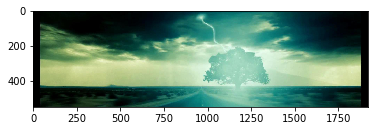

In [694]:
frames = glob.glob('../../data/Action/*.jpg')
sample = random.choice(frames)
print(sample)
img = np.asarray(Image.open('target2.jpg'))
plt.imshow(img)
plt.show()


../casual_frames/vjkOwwGarDc_2320.jpg


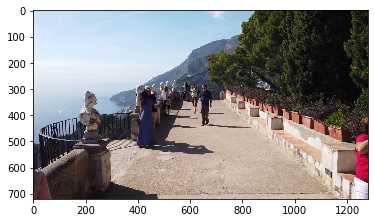

In [695]:
frames = glob.glob('../casual_frames/*.jpg')
sample2 = random.choice(frames)
print(sample2)
img2 = utils.crop_blacks(np.asarray(Image.open('source2.jpg')))
plt.imshow(img2)


In [507]:
img2_idx, color_max2 = index_image(img2, color_model, color_terms, count_table)
mask2 = search(img2_idx, 7, count_table, color_max2, len(color_terms), thresh=20)

In [529]:
mask_floats = mask2.astype(np.float32)
# print(mask_floats)
mask_floats = cv.GaussianBlur(mask_floats, (21, 21), 0)
# print(mask_floats)
mask_floats = np.repeat(mask_floats[:,:,np.newaxis], 3, axis=2)
# print(mask_floats.shape)

(-0.5, 1919.5, 817.5, -0.5)

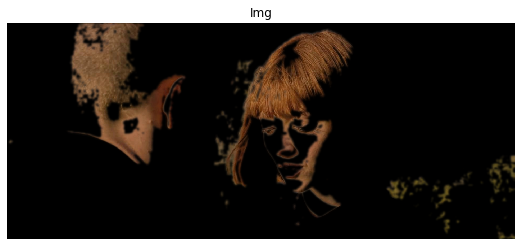

In [531]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Img")
ax.imshow(img2/255 * mask_floats)
# ax.imshow(mask_floats.astype(np.float32), alpha=1)
ax.axis("off")

(-0.5, 63.5, 63.5, -0.5)

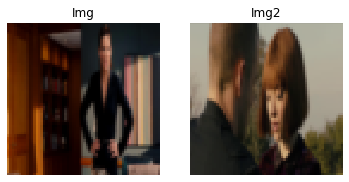

In [683]:
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

img_down = resize(img, (64, 64), anti_aliasing=True)
img2_down = resize(img2, (64, 64), anti_aliasing=True)

# img_down = resize(img_down, (200,200), Image.NEAREST)
# img2_down = resize(img2_down, (200,200), Image.NEAREST)

# Image.fromarray(img).resize((20, 20), Image.ANTIALIAS).resize((200, 200), Image.NEAREST).save('./img_down.png')
# Image.fromarray(img2).resize((20, 20), Image.ANTIALIAS).resize((200, 200), Image.NEAREST).save('./img2_down.png')

plt.figure()
ax = plt.subplot(1, 2, 1)
ax.set_title("Img")
ax.imshow(img_down)
ax.axis("off")

ax = plt.subplot(1, 2, 2)
ax.set_title('Img2')
ax.imshow(img2_down)
ax.axis("off")


# plt.tight_layout()
# plt.show()

/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[-2.33118239 -0.06812806 -0.330443  ]
 [-7.97973245  0.68567382  0.28445075]
 [ 2.80308871 -0.02532336  0.49919589]]


/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 209664 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


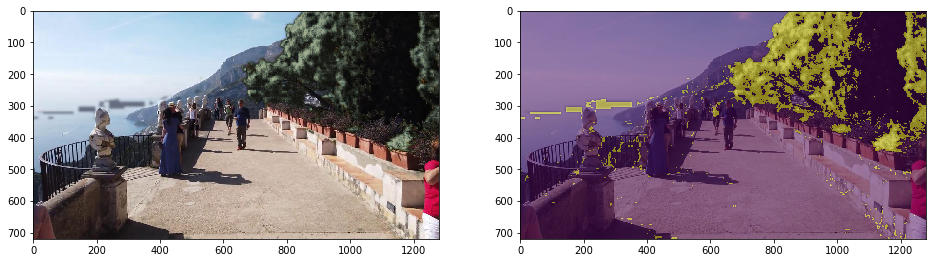

In [702]:

img2_res = np.copy(img2).reshape((-1,3))
# for color_idx in range(153):
color_idx = 0
img_idx, color_max = index_image(img_down*255, color_model, color_terms, count_table)
mask = search(img_idx, color_idx, count_table, color_max, len(color_terms), thresh=20)

img_idx2, color_max2 = index_image(img2_down*255, color_model, color_terms, count_table)
mask2 = search(img_idx2, color_idx, count_table, color_max2, len(color_terms), thresh=20)

img_lab = color.rgb2lab(img_down)
img2_lab = color.rgb2lab(img2_down)
img_down_rs = np.reshape(img_lab, (-1,3))
mask_rs = mask.flatten()
img2_down_rs = np.reshape(img2_lab, (-1,3))
mask2_rs = mask2.flatten()
# if len(np.where(mask_rs)[0]) < 20 or len(np.where(mask2_rs)[0]) < 20:
#     continue
img_pts = random.sample(list(np.where(mask_rs)[0]), 20)
img2_pts = random.sample(list(np.where(mask2_rs)[0]), 20)

transfer = np.linalg.lstsq(img2_down_rs[img2_pts], img_down_rs[img_pts])[0]
print(transfer)
img2_idx, color_max2 = index_image(img2, color_model, color_terms, count_table)
mask2 = search(img2_idx, color_idx, count_table, color_max2, len(color_terms), thresh=80)

mask_floats = mask2.astype(np.float32)
mask_floats = cv.GaussianBlur(mask_floats, (21, 21), 0)    

img2_pts = np.where(mask_floats.flatten() > 0)[0]



x = color.rgb2lab(img2).reshape((-1,3))[img2_pts].dot(transfer)
img2_transfer = np.dot(color.rgb2lab(img2).reshape((-1,3))[img2_pts], transfer)
img2_transfer = color.lab2rgb(img2_transfer.reshape((1,-1,3)))
img2_transfer = img2_transfer.reshape((-1,3))

mask_floats = np.repeat(mask_floats[:,:,np.newaxis], 3, axis=2)
img2_res[img2_pts] = img2_res[img2_pts]*(1 - .5*mask_floats.reshape((-1,3))[img2_pts]) + (img2_transfer * 255).astype(np.uint8)*(.5*mask_floats.reshape((-1,3))[img2_pts])


img2_transfered = img2_res.reshape(img2.shape)
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
ax.imshow(img2_transfered)
ax = plt.subplot(1,2,2)
ax.imshow(img2_transfered)
ax.imshow(mask2, alpha=.5)

plt.show()

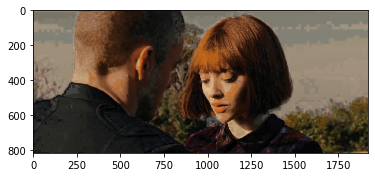

In [689]:
# img2_transfered_filt = cv.GaussianBlur(img2_transfered, (11,11), 0)
img2_transfered_filt = img2_transfered/255 * .8 + img2/255 * .2
# img2_transfered_filt = img2_transfered_filt/255 * .75 + img2/255 * .25
img2_transfered_filt = cv.GaussianBlur(img2_transfered, (3,3), 0)


plt.imshow(img2_transfered_filt)

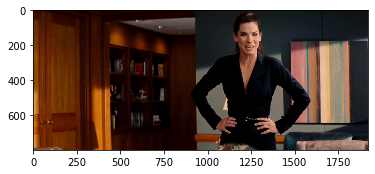

In [600]:
plt.imshow(img2)

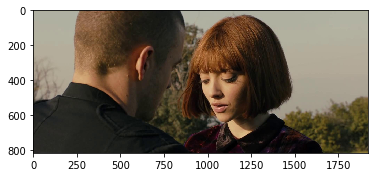

In [601]:
plt.imshow(img)

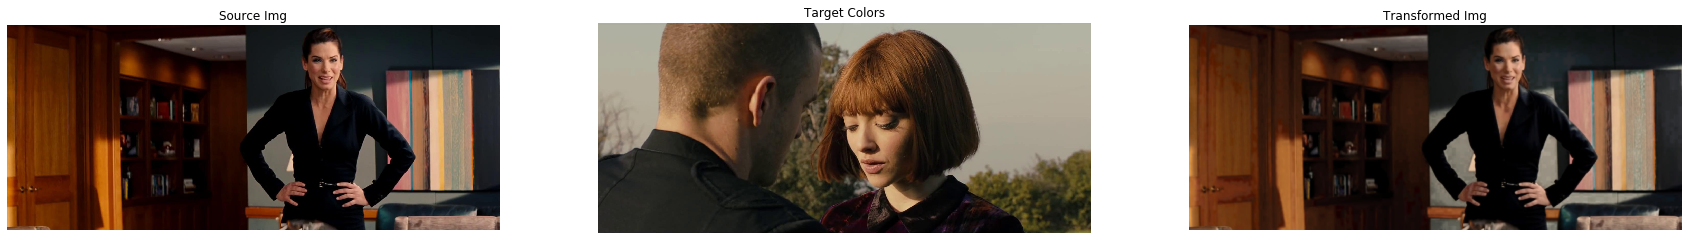

In [602]:
plt.figure(figsize=(30,10))
ax = plt.subplot(1,3,1)
ax.imshow(img2)
ax.set_title('Source Img')
ax.axis('off')
ax = plt.subplot(1,3,2)
ax.imshow(img)
ax.set_title('Target Colors')
ax.axis('off')
ax = plt.subplot(1,3,3)
ax.imshow(img2_transfered_filt)
ax.set_title('Transformed Img')
ax.axis('off')

plt.show()


In [690]:
plt.imsave('source1.jpg', img2)
plt.imsave('target1.jpg', img)
plt.imsave('transfered1.jpg', img2_transfered_filt)

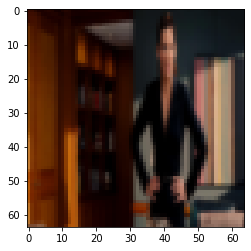

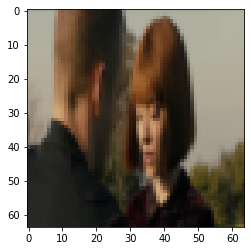

/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.
/home/bmild/anaconda2/envs/comp-color/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


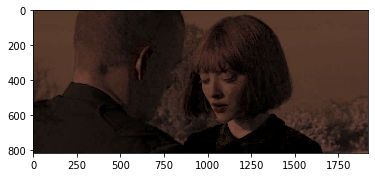

In [685]:
img_lab = color.rgb2lab(img_down)
img2_lab = color.rgb2lab(img2_down)
plt.imshow(img_down)
plt.show()
plt.imshow(img2_down)
plt.show()
img2_down_rs = img2_lab.reshape((-1,3))
img_down_rs = img_lab.reshape((-1,3))

transfer = np.linalg.lstsq(img2_down_rs, img_down_rs)[0]
img2_res = color.rgb2lab(img2).reshape((-1,3))
img2_res_transfer = img2_res.dot(transfer)
img2_transfer = img2_res_transfer.reshape(img2.shape)
img2_transfer = color.lab2rgb(img2_transfer)
plt.imshow(img2_transfer)

In [679]:
plt.imsave('transfered2_1.jpg', img2_transfered_filt)

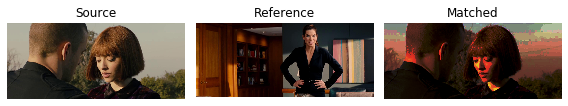

In [686]:
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

reference = img
image = img2

matched = match_histograms(image, reference, multichannel=True)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

In [691]:
plt.imsave('histmatch1.jpg', matched)